## Setup

In [1]:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from src.ftm import constants as FTM_constants
from src.knn import Knn
from src.phi import JTFS_forward
from src.dataset_utils import theta_ds_create

## KNN

In [2]:
# Only run this to recreate the parameters CSV, use the dataset in precomputed_S if you want to use the Bruteforce method

#DatasetPath = "data/default_parameters.csv"
#bounds = [['omega', 'tau', 'p', 'd', 'alpha'],[(2.4, 3.8),(0.4, 3),(-5, -0.7),(-5, -0.5),(10e-05, 1)]]
#theta_ds_create(bounds=bounds, subdiv=10, path='data/default_parameters.csv')


# Setting the parameters
DatasetPath = "data/precompute_S/param_dataset.csv"
S_DatasetPath = "data/precompute_S/S_dataset_full.parquet"
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True

# Reading the dataset
DF = torch.from_numpy(pd.read_csv(DatasetPath).to_numpy()).to(device).to(torch.float)

# KNN Params
k = 10
i_r = 1

# Main job
print('computing the KNN with P-loss...')
T_knn_ploss = Knn(DF,i_r,k,JTFS_forward,logscale,'P-loss',S_DatasetPath)

print('computing the KNN Perceptual-KNN...')
T_knn_perceptualknn = Knn(DF,i_r,k,JTFS_forward,logscale,'Perceptual-KNN',S_DatasetPath)

print('computing the KNN Bruteforce...')
T_knn_bruteforce = Knn(DF,i_r,k,JTFS_forward,logscale,'Bruteforce',S_DatasetPath)

computing the KNN with P-loss...
computing the KNN Perceptual-KNN...
computing the KNN Bruteforce...


Bruteforcing in batch: 100%|██████████| 100/100 [04:38<00:00,  2.78s/it]


# Method characterization

In [3]:
from src.distances import distance_factory
from src.phi import JTFS_forward
from src.ftm import rectangular_drum

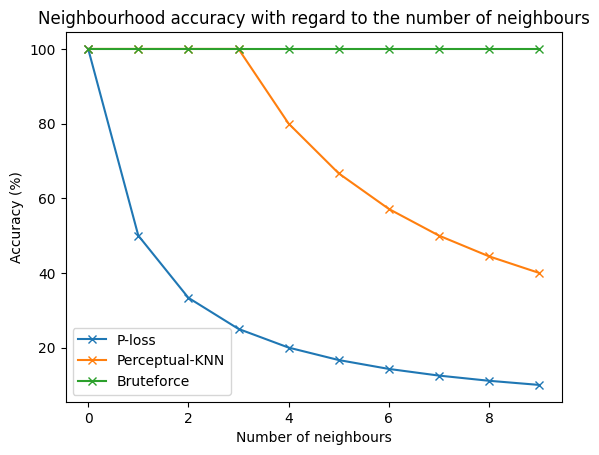

In [4]:
LMBAcc = []
LMPKNNAcc = []
LMPAcc = []

for klim in range(1,k+1):

    BruteforceAcc = 0.
    PerceptualKNNAcc = 0.
    PlossAcc = 0.

    for i_knn in range(klim):
        BruteforceAcc += (T_knn_bruteforce[i_knn,:] == T_knn_bruteforce[i_knn,:]).all()
        PerceptualKNNAcc += (T_knn_perceptualknn[i_knn,:] == T_knn_bruteforce[i_knn,:]).all()
        PlossAcc += (T_knn_ploss[i_knn,:] == T_knn_bruteforce[i_knn,:]).all()

    MeanBruteforceAcc = 100.0*BruteforceAcc/klim
    MeanPerceptualKNNAcc = 100.0*PerceptualKNNAcc/klim
    MeanPlossAcc = 100.0*PlossAcc/klim

    LMBAcc.append(MeanBruteforceAcc.cpu())
    LMPKNNAcc.append(MeanPerceptualKNNAcc.cpu())
    LMPAcc.append(MeanPlossAcc.cpu())

plt.figure(0)
x = np.linspace(0,k-1,k)
plt.plot(x,LMPAcc,'-x',x,LMPKNNAcc,'-x',x,LMBAcc,'-x')
plt.xlabel("Number of neighbours")
plt.ylabel("Accuracy (%)")
plt.legend(['P-loss', 'Perceptual-KNN', 'Bruteforce'])
plt.title("Neighbourhood accuracy with regard to the number of neighbours")
plt.show()

tensor(-0.0351, device='cuda:0')
tensor(-0.0487, device='cuda:0')
tensor(0.0212, device='cuda:0')
tensor(-0.0753, device='cuda:0')
tensor(-0.1075, device='cuda:0')
tensor(-0.0189, device='cuda:0')
tensor(0.0085, device='cuda:0')
tensor(-0.0323, device='cuda:0')
tensor(nan, device='cuda:0')
tensor(nan, device='cuda:0')


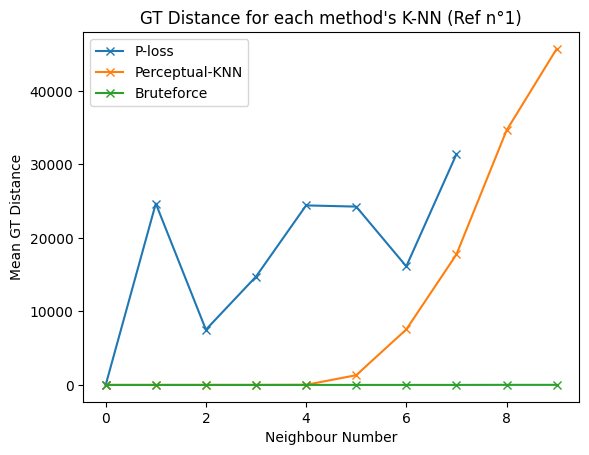

In [5]:
theta_r = T_knn_bruteforce[0,:]
x_r = rectangular_drum(theta_r, logscale, **FTM_constants)
phi = JTFS_forward
S_r = phi(x_r)

dist = distance_factory("Bruteforce")

Dploss = []
Dperceptualknn = []
Dbruteforce = []

for i in range(k):
    S_c_ploss = phi(rectangular_drum(T_knn_ploss[i,:], logscale, **FTM_constants))
    S_c_perceptual = phi(rectangular_drum(T_knn_perceptualknn[i,:], logscale, **FTM_constants))
    S_c_bruteforce = phi(rectangular_drum(T_knn_bruteforce[i,:], logscale, **FTM_constants))
    
    print(S_c_ploss[7])

    Dploss.append(dist(S_c_ploss,S_r).item())
    Dperceptualknn.append(dist(S_c_perceptual,S_r).item())
    Dbruteforce.append(dist(S_c_bruteforce,S_r).item())

plt.figure(1)
x = np.linspace(0,len(Dploss)-1,len(Dploss))
plt.plot(x,Dploss,'-x',x,Dperceptualknn,'-x',x,Dbruteforce,'-x')
plt.xlabel("Neighbour Number")
plt.ylabel("Mean GT Distance")
plt.legend(['P-loss', 'Perceptual-KNN', 'Bruteforce'])
plt.title("GT Distance for each method's K-NN (Ref n°"+str(i_r)+")")
plt.show()

# Misc

In [ ]:
#TEST THE DERIVATION PIPELINE
import functools
from src.distances import distance_factory
from src.jacobian import M_factory
from src.phi import JTFS_forward
from src.ftm import rectangular_drum
from src.ftm import constants as FTM_constants
from src.dataset_utils import S_ds_read_given_rows
DatasetPath = "data/default_parameters.csv"
DF = torch.from_numpy(pd.read_csv(DatasetPath).to_numpy()).to(device).to(torch.float)
parameters_name = ["omega","tau","p","d","alpha"]
logscale = True

# theta_r = DF[0,:]
# theta_c = DF[2,:]

# x_r = rectangular_drum(theta_r, logscale, **FTM_constants)
# phi = JTFS_forward

# s = phi(x_r)

#print(x_r.type())
#print(s.size())

#M = M_factory(logscale,phi)

#M_r = M(theta_r)

#M_r

S_DatasetPath = "data/precompute_S/S_dataset_index.parquet"

distance = distance_factory('Bruteforce')

print('reading..')
S_r_T = S_ds_read_given_rows(S_DatasetPath, [0]) #This takes a lot of time but we do it once so..
S_r = S_r_T[0,:].to(device)

print(S_r.size())


ImportError: cannot import name 'S_ds_read_single_row' from 'src.dataset_utils' (c:\Users\smale\Perso\dev\perceptual-kNN\src\dataset_utils.py)